 # Classification of Spectral Data from Serial Crystallography

 Author: Jean-Michel Boudreau

In [1]:
!pip install umap-learn

import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import umap.umap_ as umap
from sklearn import cluster

In [2]:
def read_data(data_dir):

    with os.scandir(data_dir) as it:

        num_row = 0
        num_wave = 0
        for entry in it:
            if num_row == 0:
                i = np.loadtxt(entry, delimiter = ',')
                wave = i[:, 0].transpose()
                num_wave = i.shape[0]

            num_row += 1
    
    data = np.empty((num_row, num_wave))

    with os.scandir(data_dir) as it:

        i = 0
        for entry in it:
            temp = np.loadtxt(entry, delimiter = ',')
            data[i, :] = temp[:, 1].transpose()
            i += 1
        
    return data, wave

def plot_data(data, target, n_samples):

    # If no target/label
    if len(target) == 0:
        target = np.zeros((data.shape[0], ))

    # Tableau colormap
    target_uniq = np.unique(target)
    n_col = target_uniq.size
    col = np.asarray([cm.get_cmap('tab10')(i) for i in range(n_col)])

    # Plot
    if n_col == 1:
        fig = plt.figure(figsize = (6, 6))
    else:
        fig = plt.figure(figsize = (6, 12))

    k = 1
    for i in range(n_col):

        # Find matching
        j = (target == target_uniq[i])
        n_samples = (n_samples if n_samples < np.sum(j) else np.sum(j))

        ax = fig.add_subplot(n_col, 1, k)
        plt.setp(ax, ylim = (np.min(data), np.max(data)), yscale = 'log')
        plt.setp(ax, title = f'{target_uniq[i]} ({np.sum(j)})')

        l = 0
        m = 0
        while l < n_samples:

            if j[m] == True:
                ax.plot(data[m, :], linewidth = 0.5, color = col[i, :3], label = f'{target_uniq[i]}')
                l += 1
            m += 1

        k += 1

    
    # if n_col <= 20:
    #     ax.legend(loc = 'upper left')
    

def plot_emb(data, target, str_title):

    # Embedding dimension
    n_dim_emb = data.shape[1]

    # Centroid
    # r0 = np.median(data, axis = 0)
    r0 = np.zeros((data.shape[1], 1))

    # If no target/label
    if len(target) == 0:
        target = np.zeros((data.shape[0], ))

    # Tableau colormap
    target_uniq = np.unique(target)
    n_col = target_uniq.size
    col = np.asarray([cm.get_cmap('tab10')(i) for i in range(n_col)])

    # Plot
    fig = plt.figure(figsize = (6, 6))

    # 2D
    if n_dim_emb == 2:

        ax = fig.add_subplot(111)
        # ax.scatter(data[:, 0] - r0[0], data[:, 1] - r0[1], s = 5, c = list(map(lambda i: int(mnist.target[i]), range(data.shape[0]))))
        for i in range(n_col):
            j = (target == target_uniq[i])
            ax.scatter(data[j, 0] - r0[0], data[j, 1] - r0[1], s = 1, cmap = col[i, :3], label = f'{i}')
    
    # 3D
    elif n_dim_emb == 3:

        ax = fig.add_subplot(111, projection = '3d')
        # ax.scatter(data[:, 0] - r0[0], data[:, 1] - r0[1], data[:, 2] - r0[2], s = 5, c = list(map(lambda i: int(mnist.target[i]), range(data.shape[0]))))
        for i in range(n_col):
            j = (target == target_uniq[i])
            ax.scatter(data[j, 0] - r0[0], data[j, 1] - r0[1], data[j, 2] - r0[2], s = 1, cmap = col[i, :3], label = f'{i}')
        
    # ax.set_axis_off()
    # ax.xticks([])
    # ax.yticks([])

    if n_col <= 20:
        ax.legend(loc = 'lower left')

    plt.setp(ax, title = str_title)


Elapsed time for reading data: 165.53857803344727 s
Number of files = 11654
Number of features = 2048


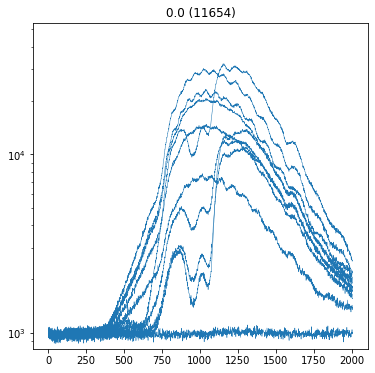

In [3]:
# Read data
#!unzip data.zip
data_dir = './data/'

t0 = time()
data, wave = read_data(data_dir)
print(f'Elapsed time for reading data: {time() - t0} s')

n_samples = data.shape[0]
n_features = data.shape[1]
print(f'Number of files = {n_samples}')
print(f'Number of features = {n_features}')

# Trim data
data = data[:, 40:]
wave = wave[40:]

plot_data(data, [], 10)


Elapsed time for UMAP: 85.88641023635864 s


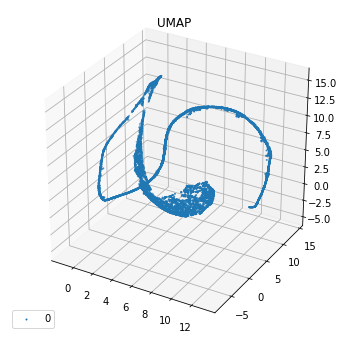

In [4]:
# UMAP parameters
n_dim_emb = 3
n_neighbors = 100
min_dist = 0.1
metric = 'euclidean'
# metric = 'correlation'

# UMAP
t0 = time()
model_umap = umap.UMAP(n_components = n_dim_emb, n_neighbors = n_neighbors, min_dist = min_dist, metric = metric, random_state = 0)
data_umap = model_umap.fit_transform(data[0:n_samples, :])
print(f'Elapsed time for UMAP: {time() - t0} s')

# Plot UMAP result
plot_emb(data_umap, [], 'UMAP')


Elapsed time for DBSCAN: 0.15399765968322754 s


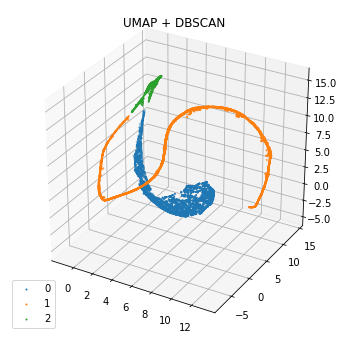

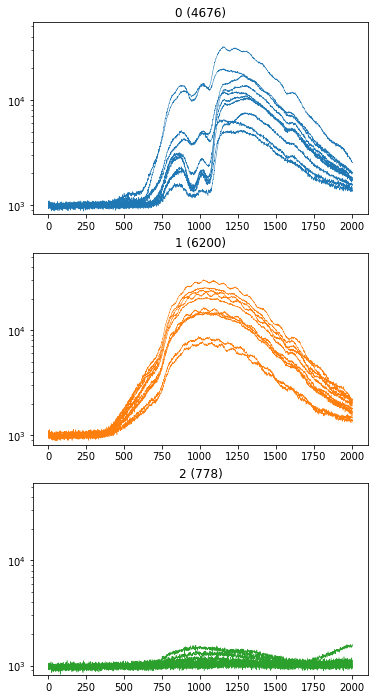

In [5]:
# DBSCAN
eps = 0.5
min_samples = 10
t0 = time()
model_dbscan = cluster.DBSCAN(eps = eps, min_samples = min_samples).fit(data_umap)
print(f'Elapsed time for DBSCAN: {time() - t0} s')

# Plot DBSCAN result
plot_emb(data_umap, model_dbscan.labels_, 'UMAP + DBSCAN')

plot_data(data, model_dbscan.labels_, 10)

# !pip install hdbscan
# import hdbscan
# # HDBSCAN
# min_cluster_size = 100
# t0 = time()
# model_hdbscan = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size).fit(data_umap)
# print(f'Elapsed time for HDBSCAN: {time() - t0} s')

# # Plot HDBSCAN result
# plot_emb(data_umap, model_hdbscan.labels_, 'UMAP + HDBSCAN')

